# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data 준비

## Data Load

In [2]:

# 데이터 불러오기
data = pd.read_csv("../data/comment_translation_predict_label.csv")  # 중복 제거된 데이터 (ex: df.iloc[1200:, :])
train_df = pd.read_csv("../data/train.csv")  # 원본 데이터



In [3]:
data

,review_comment_message,review_comment_message_en,Product_Quality,Delivery,Price,Repurchase_Intention,etc
0,"Produto preto, reembalado na caixa de um branc...","Black product, repacked in a white box, lots o...",-1,0,0,0,0
1,FICAMOS ESPERANDO UMA ENCOMENDA PAGA QUE NUNCA...,WE'RE STILL EXPERIENCED WITH A RECOMMENDATION ...,0,0,0,0,-1
2,Otimo muito bom,Very good.,0,0,0,0,1
3,Entrega antes do prazo. Produto muito bom e bo...,"It arrives by the deadline. Very good product,...",1,1,0,0,0
4,excelente.,excellent.,0,0,0,0,1
...,...,...,...,...,...,...,...
35170,"Muito obrigada , uma atenção nota 10, profissi...","Thank you very much, a note 10 for your attent...",1,0,0,1,0
35171,Produto entregue dentro do prazo . Gostei muito.,I got it delivered on time. I appreciate it.,0,1,0,0,0
35172,Essa capa não encaixa direito. Não consigo tro...,That layer doesn't fit right. I can't change it.,-1,0,0,0,0
35173,"Mim deixou esperar muito tempo, para depois vi...",So he waited a long time for me to let him kno...,0,-1,0,0,0


In [4]:
# 'review_comment_message'를 기준으로 데이터 병합
df = pd.merge(train_df, data, on='review_comment_message', how='left')
# # 불필요한 'review_comment_message' 컬럼 삭제
# df = df.drop(columns=['review_comment_message'])

# 결과 확인
print(df.head())

                           order_id                       customer_id  \
0  d455a8cb295653b55abda06d434ab492  944b72539d7e1f7f7fc6e46639ef1fe3   
1  7f39ba4c9052be115350065d07583cac  d7fc82cbeafea77bd0a8fbbf6296e387   
2  9dc8d1a6f16f1b89874c29c9d8d30447  d9442164acf4b03109425633efaa0cfc   
3  0f548bd29148ebc519d6495e37a284e1  015faf9ec36eccd957c0f2782aab09a4   
4  0f548bd29148ebc519d6495e37a284e1  015faf9ec36eccd957c0f2782aab09a4   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-09-26 22:17:05  2017-09-27 22:24:16   
1    delivered      2017-10-18 08:16:34  2017-10-18 23:56:20   
2    delivered      2017-10-12 13:33:22  2017-10-12 13:49:22   
3    delivered      2017-09-03 08:06:30  2017-09-03 08:25:50   
4    delivered      2017-09-03 08:06:30  2017-09-03 08:25:50   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-09-29 15:53:03           2017-10-07 16:12:47   
1          2017-10-20 14:29:01           2017-10

In [5]:
pt = list(pd.DataFrame(df['review_comment_message']).dropna().index)

In [6]:
len(pt)

48905

In [7]:
en = list(pd.DataFrame(df['review_comment_message_en']).dropna().index)

In [8]:
len(en)

48905

In [9]:
pt_not_in_en = list(set(pt) - set(en))

en_not_in_pt = list(set(en) - set(pt))

print("pt 리스트에 포함되지 않은 en의 원소:", pt_not_in_en)
print("en 리스트에 포함되지 않은 pt의 원소:", en_not_in_pt)

pt 리스트에 포함되지 않은 en의 원소: []
en 리스트에 포함되지 않은 pt의 원소: []


## 데이터 전처리
- 별점 O, 코멘트 X: 코멘트 length = 0으로 처리
- 별점 X, 코멘트 X: 해당 항목은 분석에서 제외 (drop)
- 별점을 준 고객은 리뷰를 남길 환경이 갖춰진 것으로 보고, 코멘트를 작성하지 않은 경우로 판단

In [10]:
df = df[df['review_score'].notnull() | df['review_comment_message_en'].notnull()]

In [11]:
len(df)

115610

In [14]:
df['review_comment_message_en'].isnull().sum()

66705

In [15]:
df['review_length'] = df['review_comment_message_en'].apply(lambda x: len(x) if pd.notnull(x) and x != "" else 0)


# 0. 리뷰 평균 길이

In [16]:
review_avg_length = df['review_length'].mean()

# 결과 출력
print(f"리뷰의 평균 길이: {review_avg_length:.2f}")


리뷰의 평균 길이: 31.24


In [17]:
median_review_length = df[df['review_length'] != 0]['review_length'].median()

# 결과 출력
print(f"리뷰의 중앙값 길이: {median_review_length:.2f}")

리뷰의 중앙값 길이: 56.00


# 1. 상위 리뷰 길이 기준

In [18]:
# 상위 10%부터 50%까지 리뷰 길이 기준으로 구간을 설정하고 각 구간별 평균 계산
percentiles = [90, 80, 70, 60, 50]  # 상위 10%부터 50%까지
length_percentile_averages = {}

for p in percentiles:
    threshold = df['review_length'].quantile(p / 100)  # 특정 백분위수에 해당하는 길이
    avg_length = df[df['review_length'] >= threshold]['review_length'].mean()
    length_percentile_averages[f"Top {100 - p}%"] = avg_length

# 결과 출력
print("상위 리뷰 길이 기준에 따른 평균 리뷰 길이:")
for percentile, avg_length in length_percentile_averages.items():
    print(f"{percentile} 평균 리뷰 길이: {avg_length:.2f}")


상위 리뷰 길이 기준에 따른 평균 리뷰 길이:
Top 10% 평균 리뷰 길이: 161.90
Top 20% 평균 리뷰 길이: 119.97
Top 30% 평균 리뷰 길이: 94.86
Top 40% 평균 리뷰 길이: 77.10
Top 50% 평균 리뷰 길이: 31.24


# 2. 부정 리뷰 길이 기준

In [20]:
# 별점 1에 해당하는 부정적 리뷰의 평균 길이 계산
negative_review_avg_length1 = df[df['review_score'] == 1]['review_length'].mean()

# 결과 출력
print(f"별점 1 부정 리뷰의 평균 길이: {negative_review_avg_length1:.2f}")
# 별점 1, 2에 해당하는 부정적 리뷰의 평균 길이 계산
negative_review_avg_length2 = df[df['review_score'].isin([1,2])]['review_length'].mean()

# 결과 출력
print(f"별점 1, 2 부정 리뷰의 평균 길이: {negative_review_avg_length2:.2f}")


별점 1 부정 리뷰의 평균 길이: 82.08
별점 1, 2 부정 리뷰의 평균 길이: 80.03


# 3. 별점에 따른 리뷰 비교

In [ ]:
# 별점 1인 리뷰의 평균 길이 계산
star_group1 = [1]
group1_avg_length = df[df['review_score'].isin(star_group1)]['review_length'].mean()

# 별점 1, 2인 리뷰의 평균 길이 계산
star_group2 = [1, 2]
group2_avg_length = df[df['review_score'].isin(star_group2)]['review_length'].mean()

# 결과 출력
print(f"별점 1, 5 리뷰의 평균 길이: {group1_avg_length:.2f}")
print(f"별점 1, 2, 4, 5 리뷰의 평균 길이: {group2_avg_length:.2f}")


별점 1, 5 리뷰의 평균 길이: 30.79
별점 1, 2, 4, 5 리뷰의 평균 길이: 30.38


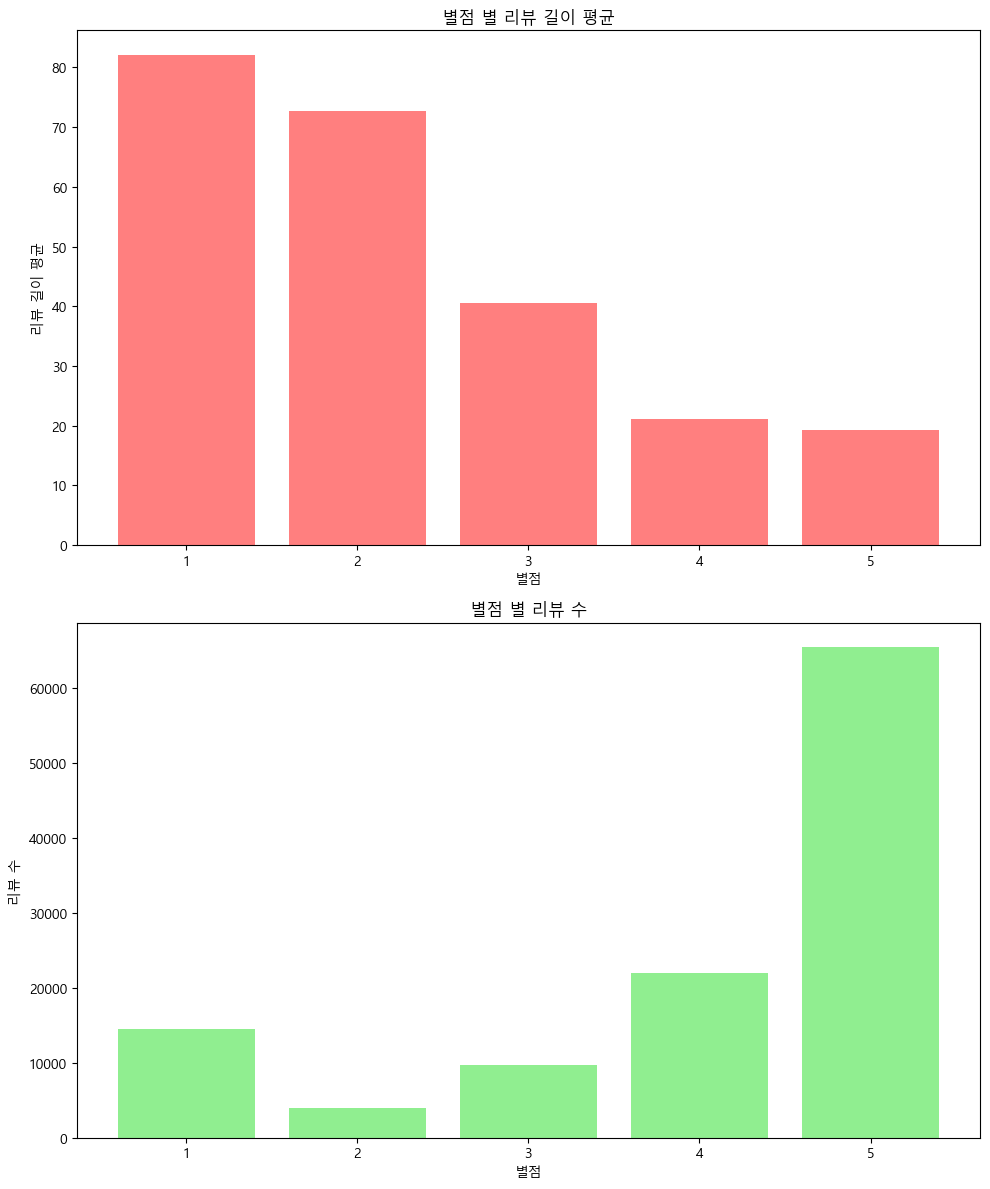

별점 별 리뷰 길이 평균:
review_score
1.0    82.081776
2.0    72.618254
3.0    40.566770
4.0    21.159810
5.0    19.369856
Name: review_length, dtype: float64

별점 별 리뷰 수:
review_score
1.0    14552
2.0     4021
3.0     9720
4.0    21951
5.0    65366
Name: count, dtype: int64


In [27]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# 별점 별 리뷰 길이 평균 계산
average_length_by_star = df.groupby('review_score')['review_length'].mean()

# 별점 별 리뷰 수 계산
count_by_star = df['review_score'].value_counts().sort_index()

# 그래프 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# 별점 별 리뷰 길이 평균 그래프
ax1.bar(average_length_by_star.index, average_length_by_star.values, color='red', alpha=0.5)
ax1.set_title("별점 별 리뷰 길이 평균")
ax1.set_xlabel("별점")
ax1.set_ylabel("리뷰 길이 평균")

# 별점 별 리뷰 수 그래프
ax2.bar(count_by_star.index, count_by_star.values, color='lightgreen')
ax2.set_title("별점 별 리뷰 수")
ax2.set_xlabel("별점")
ax2.set_ylabel("리뷰 수")

# 그래프 표시
plt.tight_layout()
plt.show()
# 결과 출력
print("별점 별 리뷰 길이 평균:")
print(average_length_by_star)

print("\n별점 별 리뷰 수:")
print(count_by_star)

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# 예시 데이터프레임 생성
np.random.seed(42)
data = {
    'customer_id': np.arange(1, 1001),
    'review_length': np.random.normal(120, 30, 1000).astype(int),
    'review_count': np.random.poisson(1.5, 1000),
    'review_score': np.random.choice([1, 2, 3, 4, 5], 1000)
}
df = pd.DataFrame(data)

### Step 1: 정액/정율 리워드에 대한 시뮬레이션 ###

# 정액 리워드 10$, 15$ 제공 그룹
fixed_rewards = [10, 15]
fixed_results = {}

for reward in fixed_rewards:
    # 정액 리워드에 따른 평균 리뷰 길이 및 빈도 분석
    reward_length = df['review_length'] + np.random.normal(10, 5, df.shape[0])
    reward_count = df['review_count'] + np.random.poisson(0.2, df.shape[0])
    
    fixed_results[f"{reward}$ Fixed"] = {
        'avg_review_length': reward_length.mean(),
        'avg_review_count': reward_count.mean()
    }

# 정율 리워드 5%, 10% 제공 그룹
rate_rewards = [0.05, 0.1]
rate_results = {}

for rate in rate_rewards:
    # 정율 리워드에 따른 평균 리뷰 길이 및 빈도 분석
    reward_length = df['review_length'] + np.random.normal(10 * rate * 10, 5, df.shape[0])
    reward_count = df['review_count'] + np.random.poisson(0.3, df.shape[0])
    
    rate_results[f"{int(rate*100)}% Rate"] = {
        'avg_review_length': reward_length.mean(),
        'avg_review_count': reward_count.mean()
    }

# Step 1 시뮬레이션 결과 출력
print("정액 리워드 결과:")
for reward, metrics in fixed_results.items():
    print(f"{reward}: 평균 리뷰 길이 {metrics['avg_review_length']:.2f}, 평균 리뷰 빈도 {metrics['avg_review_count']:.2f}")

print("\n정율 리워드 결과:")
for rate, metrics in rate_results.items():
    print(f"{rate}: 평균 리뷰 길이 {metrics['avg_review_length']:.2f}, 평균 리뷰 빈도 {metrics['avg_review_count']:.2f}")

### Step 2: 리워드 지급 시기에 대한 시뮬레이션 ###

# Step 1에서 나온 최적의 리워드 방식에 대해 1주일, 2주일, 1개월 지급 시점 비교
# 예시: 15$ Fixed 리워드를 선택하여 지급 시점 비교

timing_results = {}
timeframes = ['1_week', '2_weeks', '1_month']

for timeframe in timeframes:
    if timeframe == '1_week':
        reward_length = df['review_length'] + np.random.normal(15, 5, df.shape[0])
        reward_count = df['review_count'] + np.random.poisson(0.5, df.shape[0])
    elif timeframe == '2_weeks':
        reward_length = df['review_length'] + np.random.normal(12, 5, df.shape[0])
        reward_count = df['review_count'] + np.random.poisson(0.4, df.shape[0])
    elif timeframe == '1_month':
        reward_length = df['review_length'] + np.random.normal(10, 5, df.shape[0])
        reward_count = df['review_count'] + np.random.poisson(0.3, df.shape[0])

    timing_results[timeframe] = {
        'avg_review_length': reward_length.mean(),
        'avg_review_count': reward_count.mean()
    }

# Step 2 시뮬레이션 결과 출력
print("\n지급 시점에 따른 결과:")
for timeframe, metrics in timing_results.items():
    print(f"{timeframe}: 평균 리뷰 길이 {metrics['avg_review_length']:.2f}, 평균 리뷰 빈도 {metrics['avg_review_count']:.2f}")


정액 리워드 결과:
10$ Fixed: 평균 리뷰 길이 130.06, 평균 리뷰 빈도 1.72
15$ Fixed: 평균 리뷰 길이 129.89, 평균 리뷰 빈도 1.70

정율 리워드 결과:
5% Rate: 평균 리뷰 길이 125.01, 평균 리뷰 빈도 1.84
10% Rate: 평균 리뷰 길이 129.90, 평균 리뷰 빈도 1.84

지급 시점에 따른 결과:
1_week: 평균 리뷰 길이 134.92, 평균 리뷰 빈도 2.03
2_weeks: 평균 리뷰 길이 132.16, 평균 리뷰 빈도 1.92
1_month: 평균 리뷰 길이 130.19, 평균 리뷰 빈도 1.85


In [36]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'day_of_week_name', 'month_year', 'day_month_year',
       'day_of_week_int', 'hour', 